In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sea

## 1. CRV Transactions

In [21]:
#import library
df = pd.read_csv("CRV%20Txns.csv")
df = df[['DateTime (UTC)', 'Quantity', 'Method']]
df['Quantity'] = df['Quantity'].str.replace(",","").astype('float')


df['Quant_Cumul'] = df['Quantity'].cumsum()
df['DateTime (UTC)'] = pd.to_datetime(df['DateTime (UTC)'])
df.set_index('DateTime (UTC)', inplace = True)



,HolderAddress,Balance
0,0x989AEb4d175e16225E39E87d0D97A3360524AD80,"314,088,265.051772891553696615"
1,0xF147b8125d2ef93FB6965Db97D6746952a133934,"69,414,405.554077196366589671"
2,0x52f541764e6e90eebc5c21ff570de0e2d63766b6,"59,043,515.942902371903934912"
3,0x9B44473E223f8a3c047AD86f387B80402536B029,"27,245,677.362476803522349871"
4,0x7a16fF8270133F063aAb6C9977183D9e72835428,"24,359,046.585799788652317305"
...,...,...
9005,0xa2fa5CB4fadFC40F45ADbF6bcB8B5065F2Dcb5AE,0.00694752033421286
9006,0xd8ad82Ddb6937c1A8Ea8420F3B33Fc715937d9Fb,0.003556169091770559
9007,0x01Bc97407A965F40Ae073D561fb3e163fED62242,0.000931818574270639
9008,0xf740bda768f62afeb5650E0b978a527bCe265730,0.000053618409822


## 2. veCRV Holders

/var/folders/r4/xg6xh1n11qqdk9l26twbw4zm0000gn/T/ipykernel_93313/1912920802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_holders['Balance'] = df['Balance'].str.replace(",","").astype('float')


<Figure size 640x480 with 0 Axes>

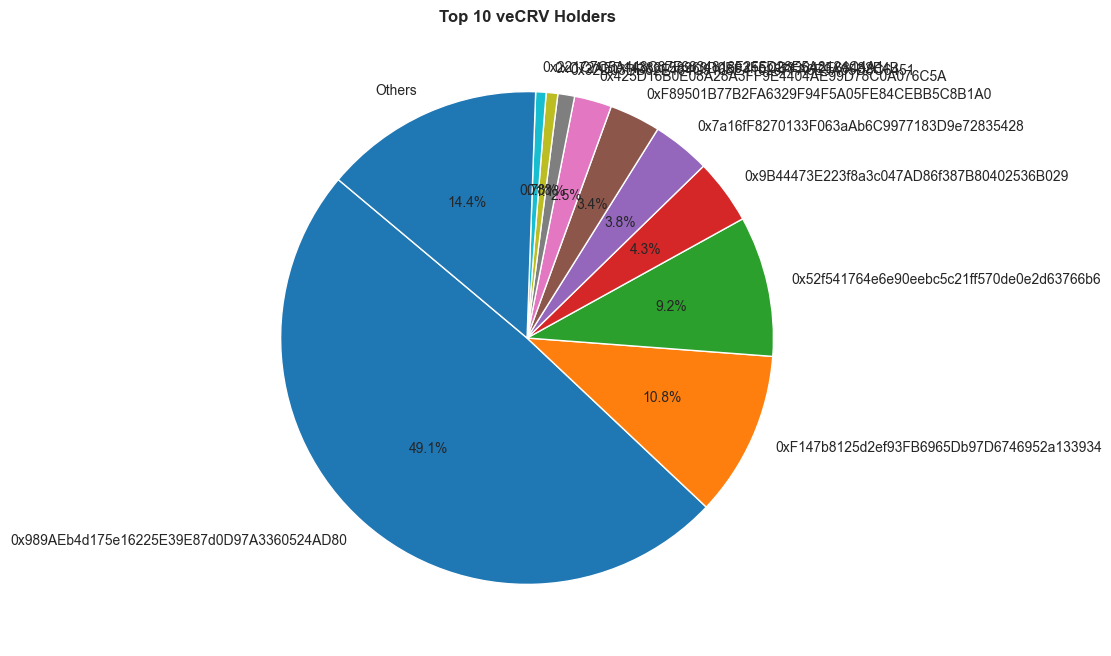

In [16]:
#loading
df = pd.read_csv("veCRV%20holders.csv")
df_holders = df[['HolderAddress','Balance']]
df_holders['Balance'] = df['Balance'].str.replace(",","").astype('float')

#prepating
top_10 = df_holders.nlargest(10, 'Balance')
others_total = df_holders['Balance'].sum() - top_10['Balance'].sum()
top_10.loc[10] = ["Others", others_total]

# Plot
plt.figure()
sea.set_style('darkgrid', {'axes.grid': True})
plt.figure(figsize=(12, 8))
plt.pie(top_10['Balance'], labels=top_10['HolderAddress'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 veCRV Holders', fontsize = 12, fontweight = 'bold')

#setting
plt.gcf().set_size_inches(11,8)
plt.gcf().set_dpi(100)


In [15]:
top_10

,HolderAddress,Balance
0,0x989AEb4d175e16225E39E87d0D97A3360524AD80,3.140883e+08
1,0xF147b8125d2ef93FB6965Db97D6746952a133934,6.941441e+07
2,0x52f541764e6e90eebc5c21ff570de0e2d63766b6,5.904352e+07
3,0x9B44473E223f8a3c047AD86f387B80402536B029,2.724568e+07
4,0x7a16fF8270133F063aAb6C9977183D9e72835428,2.435905e+07
5,0xF89501B77B2FA6329F94F5A05FE84CEBB5C8B1A0,2.146165e+07
6,0x425D16B0E08A28A3FF9E4404AE99D78C0A076C5A,1.569159e+07
7,0x32D03DB62E464C9168E41028FFA6E9A05D8C6451,7.003762e+06
8,0xC72AED14386158960D0E93FECB83642E68482E4B,4.884680e+06
9,0x221C7C5A448C87F6834818F255D28E5A8124C4A1,4.364082e+06


## 3. Trading Volume vs Correlation

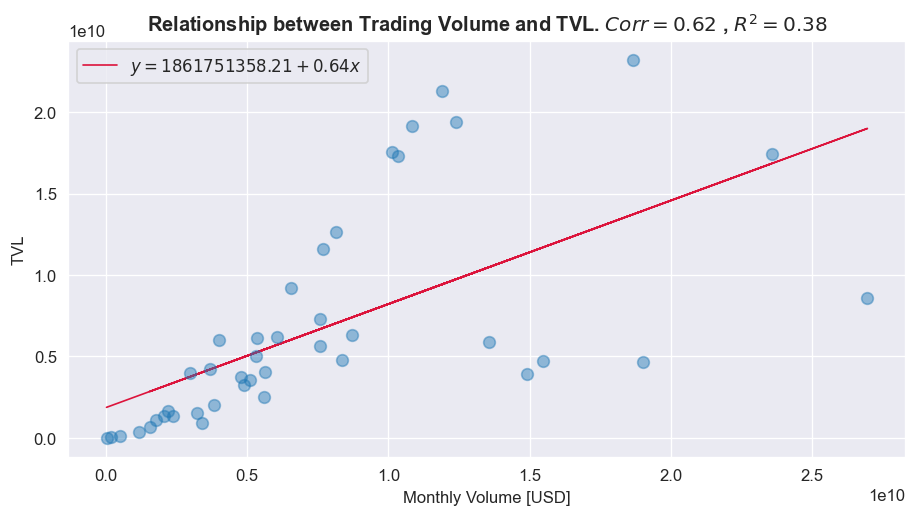

In [33]:
#Extract data prepared from Flipside
url = 'https://flipsidecrypto.xyz/api/v1/queries/20bd028e-d3da-4d62-bf41-b707837cf0d8/data/latest'
response = requests.get(url)
data = response.json()
df_corr= pd.DataFrame(data)

#Linear regression and correlation
X = df_corr['VOL_USD'].to_numpy()
Y = df_corr['TVL'].to_numpy()
linear_coef = np.polyfit(y = Y, x = X ,deg = 1)
a1,a0 = linear_coef
F = a0 + a1 *X # regression function
corr= df_corr['VOL_USD'].corr(df_corr['TVL'], method = "pearson")

# R2 - Represents the sum of squares of the residual errors of the data model.
corr_matrix = np.corrcoef(Y,F)
R_sq = corr_matrix[0,1] **2
R_sq

#Visualization
plt.figure()
sea.set_style('darkgrid', {'axis.grid': True})
plt.plot(X,F,'-', linewidth = 1, c= 'crimson', label = '$y = {} + {}x$'.format(round(a0,2),round(a1,2)))
plt.plot(X,Y,'o',linewidth = 2.4, markersize = 7, alpha = 0.45)

#labels and setting
plt.xlabel('Monthly Volume [USD]')
plt.ylabel('TVL')
plt.title(f"Relationship between Trading Volume and TVL. $Corr = {round(corr,2)}$ , $R^2 ={round(R_sq,2)}$", fontweight = 'bold')
plt.legend(loc = 'best', shadow = False, frameon = True, framealpha = 0.8)
plt.gcf().set_dpi(120)
plt.gcf().set_size_inches(9,4.5)

In [29]:
corr_matrix = np.corrcoef(Y,F)
R_sq = corr_matrix[0,1] **2
R_sq

0.3784902334024622

## 4. Forecastig Trading Volume of 3pool

In [36]:
#Extract data prepared from Flipside
url = 'https://flipsidecrypto.xyz/api/v1/queries/699c3cf7-e9bd-4b8d-9b74-124a577c6912/data/latest'
response = requests.get(url)
data = response.json()
df_pool= pd.DataFrame(data)
df_pool
#df_pool.to_csv('3pool_data.csv')


,MONTH,VOL_USD,TVL,FED_RATE
0,2020-09-01,4.560508e+08,2.838860e+08,0.09
1,2020-10-01,7.085345e+08,1.819190e+08,0.09
2,2020-11-01,7.908409e+08,3.194033e+08,0.09
3,2020-12-01,8.204292e+08,2.059953e+08,0.09
4,2021-01-01,2.691111e+09,5.294053e+08,0.09
5,2021-02-01,2.211304e+09,6.509731e+08,0.08
6,2021-03-01,2.490194e+09,9.957423e+08,0.07
7,2021-04-01,4.381350e+09,1.431535e+09,0.07
8,2021-05-01,5.338723e+09,1.292106e+09,0.06
9,2021-06-01,1.681366e+09,1.747064e+09,0.08
